# Project: Edge Finite Element Methods for Maxwell Equations

The purpose of this project is to implement the lowest order edge element
for solving the following Maxwell equations in three dimensions

$$ \nabla \times (\alpha \nabla \times \boldsymbol u) = \boldsymbol f, \quad \nabla \cdot (\beta \boldsymbol u) = 0$$

with Dirichlet boundary condition $$ \boldsymbol u\times \boldsymbol n = g_D \quad {\rm on}\; \partial \Omega.$$

The vector function $\boldsymbol u$ is approximated by the lowest order edge
element. To impose the divergence constraint, a Lagrange multiplier $p$ using the linear Lagrange element
is introduced.


Reference

[Finite Element Methods for Maxwell Equations](http://www.math.uci.edu/~chenlong/226/FEMMaxwell.pdf)

## Step 1: Data Structure

A three dimensional mesh is represented by `node, elem`. 

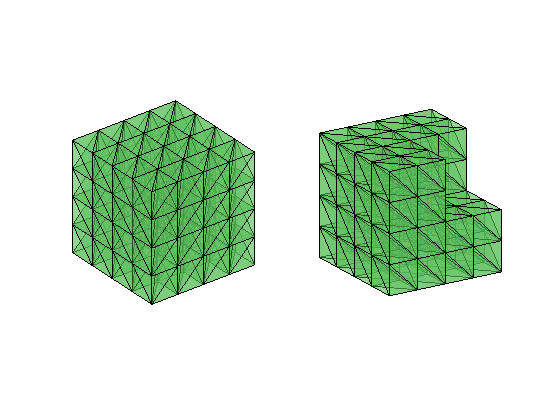

In [1]:
% A mesh for a cube
[node,elem] = cubemesh([-1,1,-1,1,-1,1],0.5);
figure(1); subplot(1,2,1); showmesh3(node,elem);
% A mesh for an L-shaped domain 
[node,elem] = cubemesh([-1,1,-1,1,-1,1],0.5);
[node,elem] = delmesh(node,elem,'x<0 & y<0 & z>0');
figure(1); subplot(1,2,2); showmesh3(node,elem); view(-122,20);

Since the unknowns are associated to edges, you need to generate edges
and more importantly the index map from the local edges in one tetrahedron to their global indices. The orientation of local edges of a tetrahedron
formed by [1 2 3 4] is lexicographic order:

    [1 2], [1 3], [1 4], [2 3], [2 4], [3 4] 

The global orientation of an edge is from the node with smaller index to
bigger one. `elem2edgeSign` records the consistency of the local and
global edge orientation.

Read [Dof on Edges in Three Dimensions](dof3edgedoc.html) for detailed discussion.

In [2]:
[elem2edge,edge,elem2edgeSign] = dof3edge(elem);

## Step 2: Assemble the Matrix Equation

Suppose [i,j] is the kth edge and orientated from i to j. The basis
associated to the kth edge is given by

$$\phi _k = \lambda_i\nabla \lambda_j - \lambda_j \nabla \lambda_i.$$

Use the following subroutine to compute $\nabla \lambda_i$

    [Dlambda,volume] = gradbasis3(node,elem);

and compute the piecewise constant vector 

$$ \nabla \times \phi _k = 2 \nabla \lambda_i \times \nabla \lambda_j $$.

Then the entry $$ ( \nabla \times \phi_k, \nabla \times \phi_l) $$ can be computed accordingly. When assemble the local entry to the global one, don't forgot the sign consistency.

The computation of (negative) weak divergence of an edge element is
changed to compute the inner product $( \phi_k, \nabla \lambda_i )$ which
is a linear combination of the entry $( \nabla \lambda_i, \nabla \lambda_j )$

Use one point quadrature to compute $(f, \phi_k).$ Again remember to
correct the sign.

## Step 4: Boundary Conditions

Modify the right hand side to include Dirichlet boundary conditions.
First of all, to set up the boundary condition use

    bdFlag = setboundary3(node,elem,'Dirichlet');

To find out the boundary edges and boundary nodes, use

    [bdEdge,bdNode,isBdEdge,isBdNode] = findboundaryedge3(edge,elem2edge,bdFlag);

Boundary nodes is needed since the boundary condition for the Lagrange
multiplier is zero on boundary nodes.

The boundary value associated to edges on the boundary is given by the
edge integral

$$ \int_E \boldsymbol u \cdot \boldsymbol t \, ds. $$

Use Simpson's rule to compute an approximation of the above integral.

## Step 5: Solve the Equation

- Use the direct solver `\` to solve the algebraic linear system
- (optional) Implement DGS Multi-Grid method to solve the system

## Step 6: Verify the Convergence 

- Substitude a smooth function into the equation to get a right hand side. Pass the data `f` and `g_D` to your subroutine to compute an approximation `u_h,p_h`.

- Compute the edge interpolant `u_I` by computing edge integrals using the formula of the exact solution `u`.

- Compare `u_I` and `u_h` in the energy norm using the curl-curl matrix.

- Compute the error `p - p_h` in the H1 norm.

- Refine mesh several times `[node,elem,bdFlag] = uniformrefine3(node,elem,bdFlag)` and show the order of convergences. 